# Building a Model to Predict Cut Made

In [67]:
import pandas as pd
from IPython.display import display

# importing data
data: pd.DataFrame = pd.read_pickle('training_data.pkl'); df = data.copy().dropna(axis=0)
display(data.head())
print(data.shape, data.columns)

,tournament_id,player_name,score,Alabama,Arizona,California,Canada,Connecticut,Delaware,Florida,...,app,ott,t2g,result,tournament_putt,tournament_arg,tournament_app,tournament_ott,tournament_t2g,tournament_cluster
0,147,Grayson Murray,-21,1,0,0,0,0,0,0,...,1,3,3,1,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,3
1,147,Chad Collins,-20,1,0,0,0,0,0,0,...,1,3,3,1,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,3
2,147,Brian Gay,-19,1,0,0,0,0,0,0,...,0,0,2,1,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,3
3,147,Scott Stallings,-19,1,0,0,0,0,0,0,...,1,0,3,1,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,3
4,147,Tag Ridings,-19,1,0,0,0,0,0,0,...,1,3,3,1,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,3


(23703, 49) Index(['tournament_id', 'player_name', 'score', 'Alabama', 'Arizona',
       'California', 'Canada', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Illinois', 'Kentucky', 'Maryland', 'Massachusetts', 'Mexico',
       'Michigan', 'Minnesota', 'Missouri', 'New Jersey', 'New York',
       'North Carolina', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Scotland',
       'South Carolina', 'Tennessee', 'Texas', 'sg_putt', 'sg_arg', 'sg_app',
       'sg_ott', 'sg_t2g', 'sg_total', 'pos', 'putting', 'arg', 'app', 'ott',
       't2g', 'result', 'tournament_putt', 'tournament_arg', 'tournament_app',
       'tournament_ott', 'tournament_t2g', 'tournament_cluster'],
      dtype='object')


## Prep Data

In [68]:
# creating a binary outcome 
df['result'] = df.pos.apply(lambda x: 1 if x != 'CUT' else 0)
df.result.value_counts()

1    12765
0    10924
Name: result, dtype: int64

## Building First Model
- This model is not bad and can predict with 85% accuracy
- We can do better by feeding model with more information

In [69]:
# starting with just strokes gained data
cols = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total', 'result']
small_data = df[cols].copy()
display(small_data.head())

# ensuring the data has no missing values
print(small_data.isna().sum())

,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,result
0,0.387,0.064,1.417,1.518,3.000,3.387,1
1,1.429,0.107,1.668,-0.067,1.707,3.137,1
2,1.017,0.944,1.093,-0.167,1.870,2.887,1
3,-0.187,0.165,1.887,1.022,3.074,2.887,1
4,2.118,0.414,-0.212,0.566,0.768,2.886,1


sg_putt     0
sg_arg      0
sg_app      0
sg_ott      0
sg_t2g      0
sg_total    0
result      0
dtype: int64


In [70]:
# need to remove missing values will just drop rows since it is such
# a small number of observations
small_data = small_data.dropna(axis=0)
print(small_data.isna().sum())

sg_putt     0
sg_arg      0
sg_app      0
sg_ott      0
sg_t2g      0
sg_total    0
result      0
dtype: int64


In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# split data
x = small_data.copy()
y = x.pop('result')

# create training and testing data
xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.33, random_state=42)

# train model
simple_model = RandomForestClassifier(random_state=42)
simple_model.fit(xtr, ytr)
print(f'overall accuracy: {simple_model.score(xte, yte)}')
print(confusion_matrix(y_true=yte, y_pred=simple_model.predict(xte)))

overall accuracy: 0.8490662573548222
[[3205  409]
 [ 771 3433]]


## A More Complex Approach
- Lets see if a more complex model is useful
- This model does perform slightly better so, it is worth trying when we add more data as well

In [72]:
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid

# convert training and testing data to tensors
xtrT, ytrT, xteT, yteT = [torch.Tensor(data.values) for data in [xtr, ytr, xte, yte]]
ytrT, yteT = ytrT.reshape(-1, 1), yteT.reshape(-1, 1)

# craft model
class FirstNN(nn.Module):
    def __init__(self) -> None:
        super(FirstNN, self).__init__()
        
        # actual model structure
        self.arch = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x) -> torch.Tensor:
        x = self.arch(x)
        return sigmoid(x)
    
model = FirstNN()
model(xtrT), ytrT.reshape(-1, 1)

(tensor([[0.4061],
         [0.4079],
         [0.5037],
         ...,
         [0.4255],
         [0.4343],
         [0.5753]], grad_fn=<SigmoidBackward0>),
 tensor([[1.],
         [1.],
         [0.],
         ...,
         [0.],
         [1.],
         [1.]]))

In [73]:
def train_loop(model, epochs, loss_fn, optimizer) -> dict:
    """
    This is a function that is to be used with a PyTorch model and helps to train model.
    
    Arguments:
        model: the model we are training (nn.Module object)
        epochs: number of iterations (int)
        loss_fn: the loss function to use for evaluation updated weights (function)
        optimizer: how the Neural Network gets updated during each epoch
        
    Returns:
        None
    """
    data = dict()
    data['loss'] = []
    data['test_loss'] = []
    
    for epoch in range(epochs):
        # forward pass
        model.train()
        preds = model(xtrT)
        
        # calculate loss
        loss = loss_fn(preds, ytrT)
        
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # testing loop
        model.eval()
        with torch.inference_mode():
            test_preds = model(xteT)
            test_loss = loss_fn(test_preds, yteT)
            
        # creating training output to show how model is learning
        if epoch % (epochs / 10) == 1:
            print(f'epoch: {epoch} loss: {loss} test loss: {test_loss}')
            
        data['loss'].append(loss.item())
        data['test_loss'].append(test_loss.item())
        
    return data

In [74]:
epochs = 550
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# training our network
data = train_loop(model, epochs, loss_fn, optimizer)

epoch: 1 loss: 0.7594466805458069 test loss: 0.7178282737731934
epoch: 56 loss: 0.35171228647232056 test loss: 0.35130542516708374
epoch: 111 loss: 0.3226436674594879 test loss: 0.3292030394077301
epoch: 166 loss: 0.31654831767082214 test loss: 0.32308730483055115
epoch: 221 loss: 0.3138197362422943 test loss: 0.32023417949676514
epoch: 276 loss: 0.31196799874305725 test loss: 0.31842297315597534
epoch: 331 loss: 0.31092044711112976 test loss: 0.31770196557044983
epoch: 386 loss: 0.3102021813392639 test loss: 0.317501038312912
epoch: 441 loss: 0.309674471616745 test loss: 0.3169926106929779
epoch: 496 loss: 0.3092762529850006 test loss: 0.31661784648895264


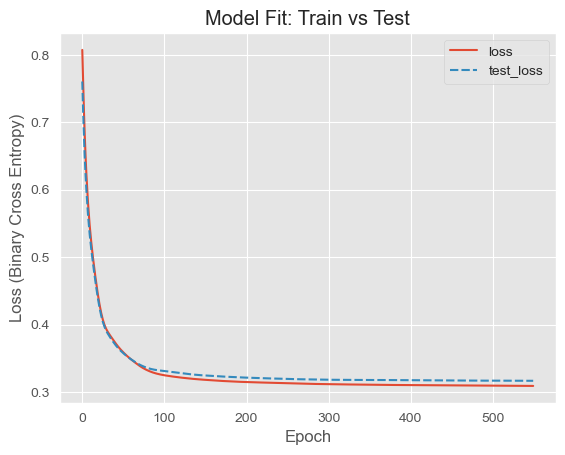

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

chart = sns.lineplot(data)
chart.set_title('Model Fit: Train vs Test')
chart.set_xlabel('Epoch')
chart.set_ylabel('Loss (Binary Cross Entropy)')
plt.show()

In [76]:
# evaluating model's performance
preds = torch.round(model(xteT))
cm = confusion_matrix(preds.detach(), yteT.detach())
print(f'overall accuracy: {(cm[0][0] + cm[1][1]) / cm.sum()}')
print(cm) 

overall accuracy: 0.8531593757994372
[[3234  768]
 [ 380 3436]]


## Lets Add Some Data
- The averages per tournament is useful information for our model
- The accuracy went from roughly 85% to 87%

In [77]:
df.columns

Index(['tournament_id', 'player_name', 'score', 'Alabama', 'Arizona',
       'California', 'Canada', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Illinois', 'Kentucky', 'Maryland', 'Massachusetts', 'Mexico',
       'Michigan', 'Minnesota', 'Missouri', 'New Jersey', 'New York',
       'North Carolina', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Scotland',
       'South Carolina', 'Tennessee', 'Texas', 'sg_putt', 'sg_arg', 'sg_app',
       'sg_ott', 'sg_t2g', 'sg_total', 'pos', 'putting', 'arg', 'app', 'ott',
       't2g', 'result', 'tournament_putt', 'tournament_arg', 'tournament_app',
       'tournament_ott', 'tournament_t2g', 'tournament_cluster'],
      dtype='object')

In [78]:
# adding data about particular golf tournaments
cols = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total', 'tournament_putt', 'tournament_arg', 'tournament_app',
       'tournament_ott', 'tournament_t2g']
middle_data = df[cols].copy()

# create binary results column
middle_data['result'] = df.pos.apply(lambda x: 1 if x != 'CUT' else 0)
print(middle_data.isna().sum())
middle_data.head()

sg_putt            0
sg_arg             0
sg_app             0
sg_ott             0
sg_t2g             0
sg_total           0
tournament_putt    0
tournament_arg     0
tournament_app     0
tournament_ott     0
tournament_t2g     0
result             0
dtype: int64


,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,tournament_putt,tournament_arg,tournament_app,tournament_ott,tournament_t2g,result
0,0.387,0.064,1.417,1.518,3.000,3.387,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1
1,1.429,0.107,1.668,-0.067,1.707,3.137,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1
2,1.017,0.944,1.093,-0.167,1.870,2.887,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1
3,-0.187,0.165,1.887,1.022,3.074,2.887,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1
4,2.118,0.414,-0.212,0.566,0.768,2.886,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1


In [79]:
# cleaning up the dataset
middle_data = middle_data.dropna(axis=0)

# split data
x = middle_data.copy()
y = x.pop('result')

xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.33, random_state=42)

# train model
bit_better = RandomForestClassifier(random_state=42)
bit_better.fit(xtr, ytr)

# measure model
print(bit_better.score(xte, yte))
preds = bit_better.predict(xte)
cm = confusion_matrix(preds, yte)
cm

0.8733691481197237


array([[3328,  704],
       [ 286, 3500]])

## Adding Clusters
- To try to group both tournaments and players I perfromed K-Means clustering on different player statistics as well as the different tournaments

In [80]:
df.columns

Index(['tournament_id', 'player_name', 'score', 'Alabama', 'Arizona',
       'California', 'Canada', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Illinois', 'Kentucky', 'Maryland', 'Massachusetts', 'Mexico',
       'Michigan', 'Minnesota', 'Missouri', 'New Jersey', 'New York',
       'North Carolina', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Scotland',
       'South Carolina', 'Tennessee', 'Texas', 'sg_putt', 'sg_arg', 'sg_app',
       'sg_ott', 'sg_t2g', 'sg_total', 'pos', 'putting', 'arg', 'app', 'ott',
       't2g', 'result', 'tournament_putt', 'tournament_arg', 'tournament_app',
       'tournament_ott', 'tournament_t2g', 'tournament_cluster'],
      dtype='object')

In [81]:
# adding some data for our final model
cols = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total',
       'tournament_putt', 'tournament_arg', 
       'tournament_app', 'tournament_ott', 'tournament_t2g',
        'putting', 'arg', 'app', 'ott', 't2g', 'tournament_cluster'
       ]
moreeee = df[cols].copy()
moreeee['result'] = df.pos.apply(lambda x: 1 if x != 'CUT' else 0)

# looking at data
moreeee.head()

,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,tournament_putt,tournament_arg,tournament_app,tournament_ott,tournament_t2g,putting,arg,app,ott,t2g,tournament_cluster,result
0,0.387,0.064,1.417,1.518,3.000,3.387,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1,1,1,3,3,3,1
1,1.429,0.107,1.668,-0.067,1.707,3.137,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1,4,1,3,3,3,1
2,1.017,0.944,1.093,-0.167,1.870,2.887,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,0,2,0,0,2,3,1
3,-0.187,0.165,1.887,1.022,3.074,2.887,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1,4,1,0,3,3,1
4,2.118,0.414,-0.212,0.566,0.768,2.886,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1,4,1,3,3,3,1


In [82]:
# checking for null values
info = pd.DataFrame((moreeee.isna().sum(), moreeee.dtypes)).transpose()
info.columns = ['null-counts', 'dtype']
info

,null-counts,dtype
sg_putt,0,float64
sg_arg,0,float64
sg_app,0,float64
sg_ott,0,float64
sg_t2g,0,float64
sg_total,0,float64
tournament_putt,0,float64
tournament_arg,0,float64
tournament_app,0,float64
tournament_ott,0,float64


In [83]:
# dropping null rows
moreeee = moreeee.dropna(axis=0)

# spliting into x and y
x = moreeee.copy()
y = x.pop('result')

# creating training and test datasets
xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.33, random_state=42)
xtr.shape, xte.shape

((15871, 17), (7818, 17))

In [84]:
# build and fit the model
best = RandomForestClassifier(random_state=42)
best.fit(xtr, ytr)
preds = best.predict(xte)

# evaluate model
print(best.score(xte, yte))
print(confusion_matrix(preds, yte))

0.8709388590432335
[[3326  721]
 [ 288 3483]]


In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# build a model pipeline to scale data because the new data did not improve performance much
my_pipeline = Pipeline([('scaler', StandardScaler()), 
                        ('forest', RandomForestClassifier(random_state=42))])
my_pipeline.fit(xtr, ytr)
preds = my_pipeline.predict(xte)

# evaluate new model
print(my_pipeline.score(xte, yte))
print(confusion_matrix(preds, yte))

0.8706830391404451
[[3325  722]
 [ 289 3482]]


In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

# tweaking how the clusters are represented
# I converted to one hot encoding or dummy vars
# splitting into x and y
x = moreeee.copy()
y = x.pop('result')

# transforming dataframe
cols_change = ['putting', 'arg', 'app', 'ott', 't2g', 'tournament_cluster']
cols_nochange = [i for i in x.columns if i not in cols_change]
col_trans = ColumnTransformer([('one hot', OneHotEncoder(sparse_output=False), cols_change),
                              ('nothing', StandardScaler(), cols_nochange)])
x = col_trans.fit_transform(x)

# creating training and test datasets
xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.33, random_state=42)

In [87]:
# build new model
best = RandomForestClassifier(random_state=42)
best.fit(xtr, ytr)
preds = best.predict(xte)

# evaluate model / this model is worse
print(best.score(xte, yte))
print(confusion_matrix(preds, yte))

0.8679969301611665
[[3312  730]
 [ 302 3474]]


## Add All Data
- Add data about states

In [88]:
# splitting data
everything = df.copy().iloc[:, 3:]
x = everything
x = x.drop('pos', axis=1)
y = x.pop('result')

# creating training and test datasets
xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.33, random_state=42)
xtr.head()

,Alabama,Arizona,California,Canada,Connecticut,Delaware,Florida,Georgia,Hawaii,Illinois,...,arg,app,ott,t2g,tournament_putt,tournament_arg,tournament_app,tournament_ott,tournament_t2g,tournament_cluster
10912,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,-0.132679,-0.086494,-0.171699,-0.093051,-0.351314,3
8121,0,0,0,0,0,0,0,0,0,0,...,4,1,3,3,-0.169723,-0.080538,-0.139765,-0.027504,-0.248076,1
3938,0,0,0,0,1,0,0,0,0,0,...,4,1,0,3,-0.199404,-0.055135,-0.166006,-0.096603,-0.317731,3
8695,0,0,0,0,0,0,0,0,0,0,...,4,1,0,3,-0.133587,-0.079271,-0.165665,-0.056310,-0.301587,4
21832,0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,-0.107114,-0.037047,-0.115369,-0.102081,-0.254295,4


In [89]:
# build and fit model
i_hope_good = RandomForestClassifier(random_state=42)
i_hope_good.fit(xtr, ytr)

# model evaluation
i_hope_good.score(xte, yte)

0.8736249680225121

## Lets Try Some Optimization
- Will try to use different models
- Will treak parameters of models
- I have found that when predicting the cut the dataset can be much narrower, only including strokes gained data and the averages of the tournaments

In [90]:
# look at data
middle_data.head()

,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,tournament_putt,tournament_arg,tournament_app,tournament_ott,tournament_t2g,result
0,0.387,0.064,1.417,1.518,3.000,3.387,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1
1,1.429,0.107,1.668,-0.067,1.707,3.137,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1
2,1.017,0.944,1.093,-0.167,1.870,2.887,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1
3,-0.187,0.165,1.887,1.022,3.074,2.887,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1
4,2.118,0.414,-0.212,0.566,0.768,2.886,-0.125295,-0.053159,-0.217258,-0.091008,-0.361742,1


In [91]:
# split data into 3 sets: training, testing, validation
shuffled = middle_data.sample(frac=1, random_state=42)
train_size = round(shuffled.shape[0] * 0.5)
test_size = round(train_size * 0.5)
print(train_size, test_size)

train = shuffled.iloc[:train_size, :]
print(train.shape)

test = shuffled.iloc[train_size: train_size + test_size + 1, :]
print(test.shape)

validation = shuffled.iloc[train_size+test_size:, :]
print(validation.shape)

# splitting into x and y
xtr = train
ytr = xtr.pop('result')

xte = test
yte = xte.pop('result')

xv = validation
yv = xv.pop('result')

11844 5922
(11844, 12)
(5923, 12)
(5923, 12)


In [92]:
# first model: Decision Tree
from sklearn.tree import DecisionTreeClassifier

# build model
tree = DecisionTreeClassifier(random_state=42)
tree.fit(xtr, ytr)
tree.score(xte, yte)

0.850413641735607

In [93]:
# second model: Random Forest
# build model
forest = RandomForestClassifier(random_state=42)
forest.fit(xtr, ytr)
forest.score(xte, yte)

0.8755698125949688

In [94]:
# third model: K-NN 15
from sklearn.neighbors import KNeighborsClassifier

# build model
knn15 = KNeighborsClassifier(n_neighbors=15)
knn15.fit(xtr, ytr)
knn15.score(xte, yte)

0.8455174742529123

In [95]:
# fourth model: SVM
from sklearn.svm import SVC

# build model
svm = SVC(random_state=42)
svm.fit(xtr, ytr)
svm.score(xte, yte)

0.8598683099780516

In [96]:
# fifth model: GradientBoosting
from sklearn.ensemble import GradientBoostingClassifier

# build model
grad = GradientBoostingClassifier(random_state=42)
grad.fit(xtr, ytr)
grad.score(xte, yte)

0.8726996454499409

In [97]:
### Run to find best params

# # will try to optimize RandomForest because it had the highest accuracy
# from sklearn.model_selection import GridSearchCV

# # parameters
# params = {
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': [i for i in range(5, 35, 5)],
#     'min_samples_split': [i for i in range(1, 1000, 100)],
#     'min_samples_leaf': [i for i in range(1, 1000, 100)],
#     'max_features': ['sqrt', 'log2', None]
# }
# forest = RandomForestClassifier(random_state=42, n_jobs=-1)

# # optimized model
# best_model = GridSearchCV(forest, params)
# best_model.fit(xtr, ytr)
# best_model.score(xte, yte)

In [110]:
import pickle

# using params found by grid search
best_params = {'criterion': 'entropy',
 'max_depth': 25,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 1}

# define model
best_model = RandomForestClassifier(criterion='entropy', max_depth=25, max_features=None, 
                                    min_samples_leaf=1, random_state=42, n_jobs=-1)
best_model.fit(xtr, ytr)
best_model.score(xte, yte)

# saving the model
filename = 'made_the_cut.sav'
pickle.dump(model, open(filename, 'wb'))

In [114]:
# final model performance on unseen validation data
preds = best_model.predict(xv)
print(best_model.score(xv, yv))
print(confusion_matrix(preds, yv, normalize="true"))

0.8975181495863582
[[0.85058978 0.14941022]
 [0.05259491 0.94740509]]


In [112]:
xv.columns

Index(['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total',
       'tournament_putt', 'tournament_arg', 'tournament_app', 'tournament_ott',
       'tournament_t2g'],
      dtype='object')

## The Final Model

In [113]:
import pickle

with open('made_the_cut.sav', 'rb') as the_model:
    made_the_cut = pickle.load(the_model)

In [109]:
print(made_the_cut.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=25, max_features=None,
                       min_samples_split=1, n_jobs=-1, random_state=42)
